<a href="https://colab.research.google.com/github/Y-coder24/leetcode-master/blob/master/FinML_Loan_Classification(8-21).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan Classification

In [25]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "../.."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    try:
        plt.savefig(path, format='png', dpi=300)
    except:
        plt.savefig(fig_id + ".png", format='png', dpi=300)

# Loans - Exploratory Data Analysis (EDA)

In [31]:
from pathlib import Path

df = pd.read_csv('https://storage.googleapis.com/public-quant/course//content/loans.csv')

有没有房子：mortgage





In [32]:
df['home_ownership'].value_counts()


,count
home_ownership,
MORTGAGE,51059
RENT,42454
OWN,8731
OTHER,136
NONE,8


In [30]:
df.filter(like='home').head()

,home_ownership
0,RENT
1,RENT
2,RENT
3,RENT
4,RENT


In [ ]:
# Replace the name of some columns
df = df.rename(columns={"loan_amnt": "loan_amount", "funded_amnt": "funded_amount", "funded_amnt_inv": "investor_funds",
                       "int_rate": "interest_rate", "annual_inc": "annual_income"})

# Drop irrelevant columns
df.drop(['id', 'member_id', 'emp_title', 'url', 'desc', 'zip_code', 'title'], axis=1, inplace=True)


## Similar Distributions:
<a id="similar_distributions"></a>
We will start by exploring the distribution of the loan amounts and see when did the loan amount issued increased significantly. <br>

<h4> What we need to know: </h4> <br>
<ul>
<li> Understand what amount was <b>mostly issued</b> to borrowers. </li>
<li> Which <b>year</b> issued the most loans. </li>
<li> The distribution of loan amounts is a <b>multinomial distribution </b>.</li>
</ul>


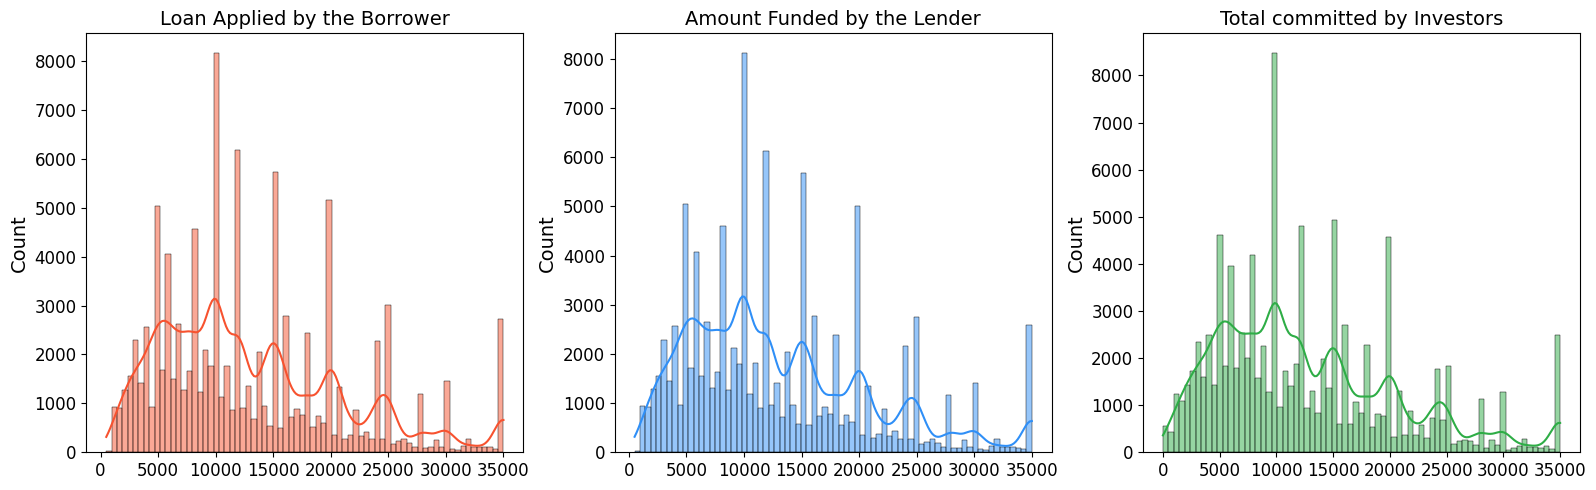

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = df["loan_amount"].values
funded_amount = df["funded_amount"].values
investor_funds = df["investor_funds"].values

sns.histplot(loan_amount, ax=ax[0], color="#F7522F", kde=True)
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.histplot(funded_amount, ax=ax[1], color="#2F8FF7", kde=True)
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.histplot(investor_funds, ax=ax[2], color="#2EAD46", kde=True)
ax[2].set_title("Total committed by Investors", fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
df['issue_d'].head()
dt_series = pd.to_datetime(df['issue_d'], errors = 'coerce')
df['year'] = dt_series.dt.year

<ipython-input-16-c9cbe11d0309>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt_series = pd.to_datetime(df['issue_d'], errors = 'coerce')


Loan Status and Issuance Amount: </h2>
<a id="types_of_loans"></a>
In this section, we will see what is the amount of bad loans declared so far, of course we have to understand that there are still loans that are at a risk of defaulting in the future.


In [ ]:
df["loan_status"].value_counts()

,count
loan_status,
Fully Paid,54314
Current,32417
Charged Off,11237
Does not meet the credit policy. Status:Fully Paid,1988
Late (31-120 days),969
Does not meet the credit policy. Status:Charged Off,761
In Grace Period,457
Late (16-30 days),153
Default,92


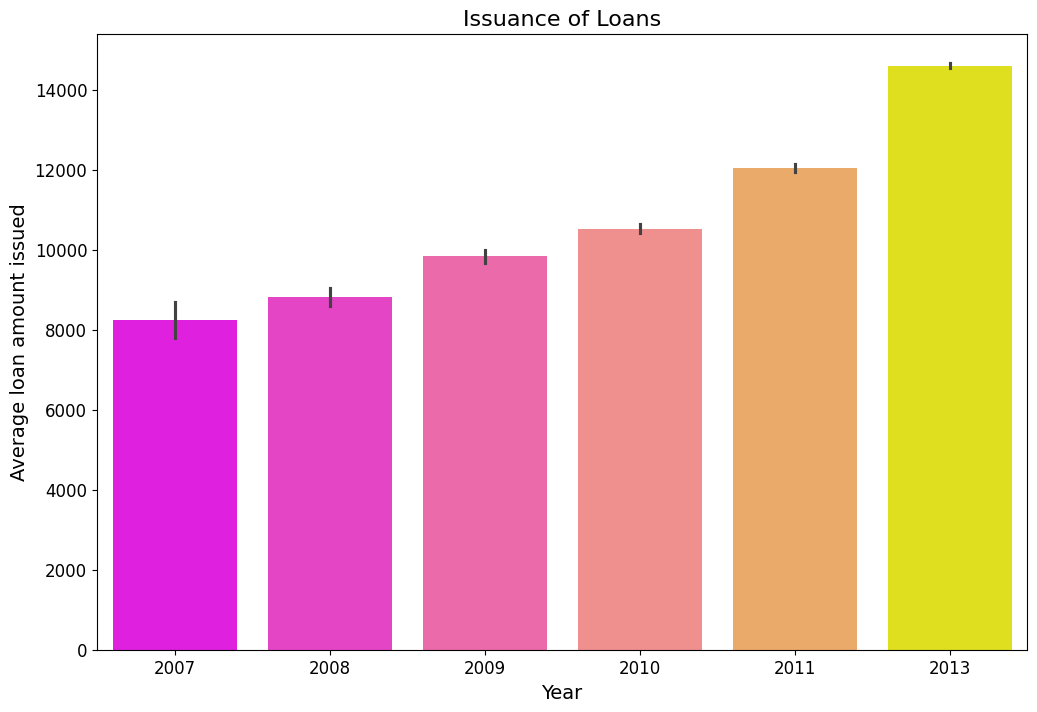

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
sns.barplot(x='year', y='loan_amount', data=df, hue='year', palette='spring', legend=False)
plt.title('Issuance of Loans', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average loan amount issued', fontsize=14)
plt.show()

## The Importance of Credit Scores:
<a id="credit_scores"></a>
Credit scores are important metrics for assesing the overall level of risk. In this section we will analyze the level of risk as a whole and how many loans were bad loans by the type of grade received in the credit score of the customer.

<h4> What we need to know: </h4>
<ul>
<li> The lower the grade of the credit score, the higher the risk for investors. </li>
<li> There are different factors that influence on the level of risk of the loan.</li>
</ul>

<h4> Summary: </h4>
<ul>
<li> The scores that has a lower grade received a larger amounts of loans (which might had contributed to a higher level of risk). </li>
<li> Logically, the <b>lower the grade the higher the interest</b> the customer had to pay back to investors.</li>
<ul>

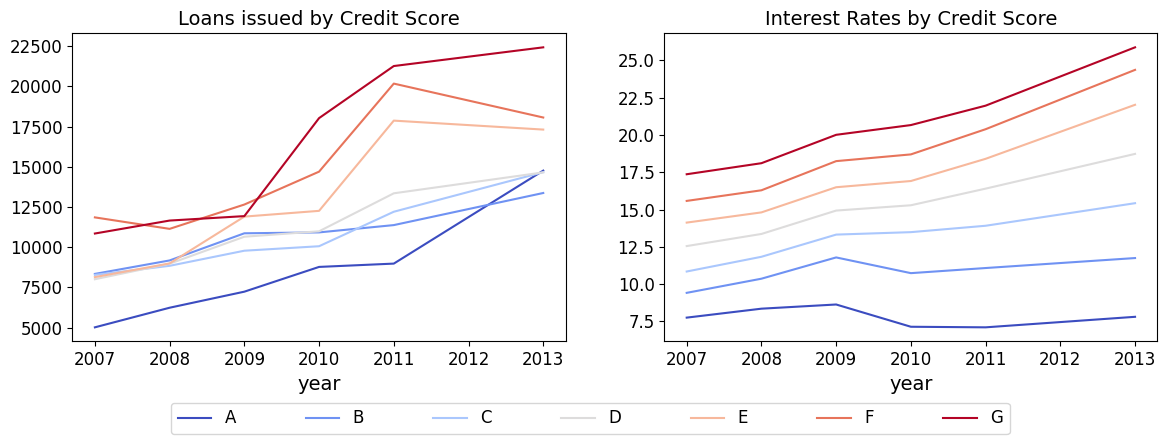

In [ ]:
# Let's visualize how many loans were issued by creditscore
f, ((ax1, ax2)) = plt.subplots(1, 2)
cmap = plt.cm.coolwarm

by_credit_score = df.groupby(['year', 'grade']).loan_amount.mean()
by_credit_score.unstack().plot(legend=False, ax=ax1, figsize=(14, 4), colormap=cmap)
ax1.set_title('Loans issued by Credit Score', fontsize=14)


by_inc = df.groupby(['year', 'grade']).interest_rate.mean()
by_inc.unstack().plot(ax=ax2, figsize=(14, 4), colormap=cmap)
ax2.set_title('Interest Rates by Credit Score', fontsize=14)

ax2.legend(bbox_to_anchor=(-1.0, -0.3, 1.7, 0.1), loc=5, prop={'size':12},
           ncol=7, mode="expand", borderaxespad=0.)

Text(0, 0.5, 'Interest Rate (%)')

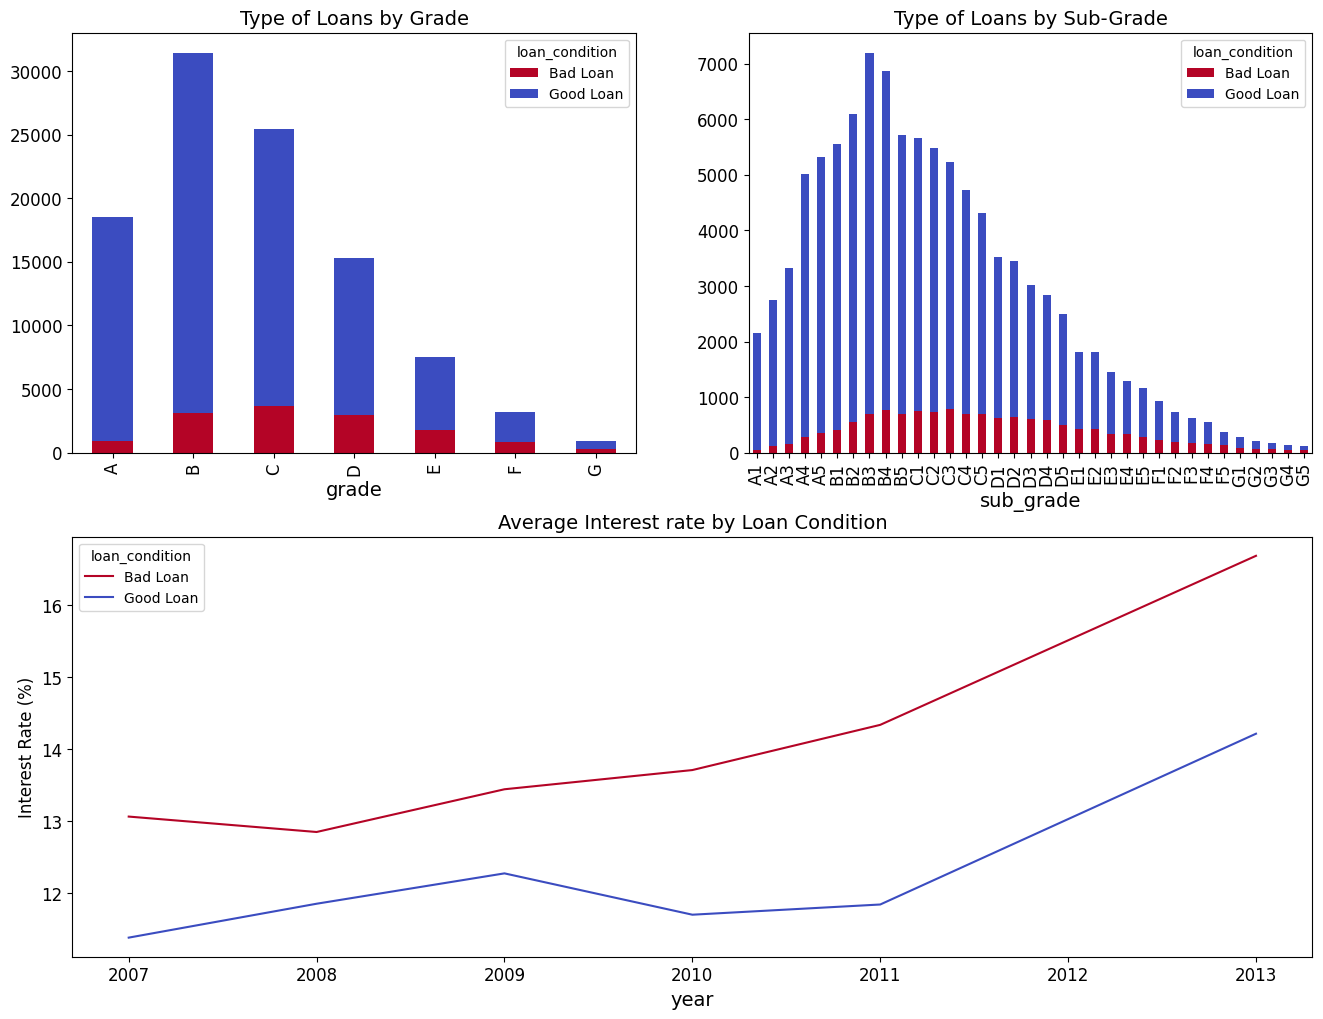

In [ ]:
# Determining the loans that are bad from loan_status column
%matplotlib inline

bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period",
            "Late (16-30 days)", "Late (31-120 days)"]


df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'


df['loan_condition'] = df['loan_status'].apply(loan_condition)


fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

cmap = plt.cm.coolwarm_r

loans_by_region = df.groupby(['grade', 'loan_condition']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Type of Loans by Grade', fontsize=14)


loans_by_grade = df.groupby(['sub_grade', 'loan_condition']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax2, grid=False)
ax2.set_title('Type of Loans by Sub-Grade', fontsize=14)

by_interest = df.groupby(['year', 'loan_condition']).interest_rate.mean()
by_interest.unstack().plot(ax=ax3, colormap=cmap)
ax3.set_title('Average Interest rate by Loan Condition', fontsize=14)
ax3.set_ylabel('Interest Rate (%)', fontsize=12)

## Data Cleaning and Feature Engineering

In [ ]:
target_list = [1 if i=='Bad Loan' else 0 for i in df['loan_condition']]

df['loan_condition'] = target_list
df['loan_condition'].value_counts()

,count
loan_condition,
0,88719
1,13669


Text(0, 0.5, 'Data type')

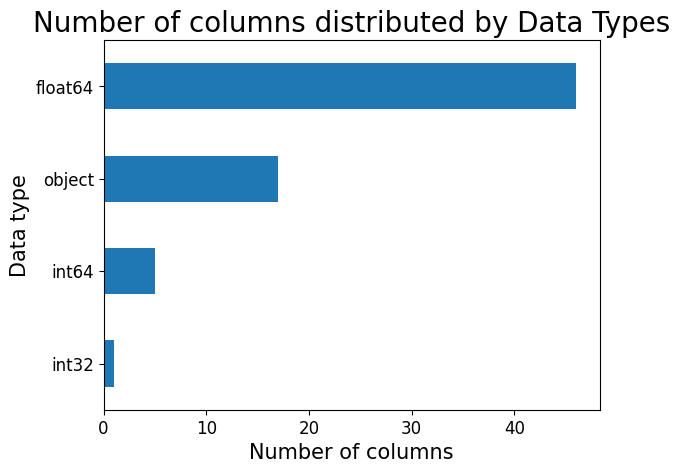

In [ ]:
# Number of columns for each data type
df.dtypes.value_counts().sort_values().plot(kind='barh')
plt.title('Number of columns distributed by Data Types',fontsize=20)
plt.xlabel('Number of columns',fontsize=15)
plt.ylabel('Data type',fontsize=15)

We would want to label encode the columns that have 2 categories and one-hot encode columns with more than 2 categories. Also, columns like emp_title, url, desc, etc. should be dropped because there aren't any large number of unique data for any of the categories they contain. Principal Component Analysis can also be carried out for the one-hot encoded columns to bring the feature dimensions down.

In [ ]:
df.head()

,loan_amount,funded_amount,investor_funds,term,interest_rate,installment,grade,sub_grade,emp_length,home_ownership,...,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,year,loan_condition
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,0
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,1
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,0
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,0
4,3000,3000,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,0




First, I'll be converting the date object columns into integer number of years or months just because I do not want to blow up the number of feature columns by performing one-hot encoding on them. For filling the null values I have taken the dates with the highest number of counts.


In [ ]:
df['issue_d']= pd.to_datetime(df['issue_d']).apply(lambda x: int(x.strftime('%Y')))
df['last_pymnt_d']= pd.to_datetime(df['last_pymnt_d'] .fillna(str(df['last_pymnt_d'].mode().values[0])),format='%d/%m/%y').dt.month
df['last_credit_pull_d']= pd.to_datetime(df['last_credit_pull_d'] .fillna(str(df['last_credit_pull_d'].mode().values[0])),format='%d/%m/%y').dt.month
df['earliest_cr_line']= pd.to_datetime(df['earliest_cr_line'] .fillna(str(df['earliest_cr_line'].mode().values[0])),format='%d/%m/%y').dt.month
df['next_pymnt_d'] = pd.to_datetime(df['next_pymnt_d'] .fillna(str(df['next_pymnt_d'].mode().values[0])),format='%d/%m/%y').dt.year

<ipython-input-28-f246a2a4a70a>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['issue_d']= pd.to_datetime(df['issue_d']).apply(lambda x: int(x.strftime('%Y')))


Some more cleanup

In [ ]:
df['mths_since_last_delinq'] = df['mths_since_last_delinq'].fillna(df['mths_since_last_delinq'].median())
df['emp_length'].fillna(value=0,inplace=True)
df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)

Let's see how we can handle our categorical data. Two of the methods we can use are Label Encoding and One Hot Encoding. The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. So, If we only have two unique values for a categorical variable (such as Yes/No), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the better option. However, due to the large number of columns originated after One-Hot Encoding, we may have to conduct Principle Component Analysis (PCA) for dimensionality reduction.


In [ ]:
from sklearn import preprocessing
count = 0

for col in df:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            le = preprocessing.LabelEncoder()
            df[col] = le.fit_transform(df[col])
            count += 1
            print (col)

print('%d columns were label encoded.' % count)

term
pymnt_plan
initial_list_status
application_type
4 columns were label encoded.



And one-hot encoding the rest of the categorical columns,


In [ ]:
cols_drop = ["loan_status","loan_condition"]
extra_cols = df[cols_drop]
df = pd.get_dummies(df.drop(cols_drop, axis=1))
df = pd.concat((extra_cols, df),axis=1)

For the 'mths_since_last_delinq' column, I'll be filling in the missing value with the median of the columns as the data in the column is continuous.

Let me remove all the columns with more than 70% missing data as they won't be helping for modelling and exploration.

In [ ]:
temp = [i for i in df.count()<len(df) *0.30]
df.drop(df.columns[temp],axis=1,inplace=True)

Drop the rows records with null values; in practice you should find a way to fill these values.

In [ ]:
df.dropna(inplace=True)

Now we have about 60,000 records left

# Binary classifier

In [ ]:
X = df.drop(["loan_condition","loan_status"],axis=1).values
y = df["loan_condition"].values

In [ ]:
len(df)

59815

In [ ]:
X_train, X_test, y_train, y_test = X[:40000], X[40000:], y[:40000], y[40000:]

In [ ]:
import numpy as np

shuffle_index = np.random.permutation(40000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
y_train_c = y_train.copy()

In [ ]:
df.head()

,loan_status,loan_condition,loan_amount,funded_amount,investor_funds,term,interest_rate,installment,annual_income,issue_d,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
42535,Current,0,27050,27050,27050.0,0,10.99,885.46,55000.0,2013,...,False,False,False,False,False,False,False,False,False,False
42536,Current,0,9750,9750,9750.0,0,13.98,333.14,26000.0,2013,...,False,False,False,False,False,False,False,False,False,False
42537,Current,0,12000,12000,12000.0,0,6.62,368.45,105000.0,2013,...,False,False,False,False,False,False,False,False,False,False
42538,Fully Paid,0,12000,12000,12000.0,0,13.53,407.40,40000.0,2013,...,False,False,False,False,False,False,False,False,False,False
42539,Current,0,15000,15000,15000.0,0,8.90,476.30,63000.0,2013,...,False,False,False,False,False,False,False,False,False,False


**Note**: a few hyperparameters will have a different default value in future versions of Scikit-Learn, so a warning is issued if you do not set them explicitly.

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss='hinge', alpha=0.0001, max_iter=1000, tol=1e-3, random_state=42)

print(sgd_clf.get_params())

{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'l2', 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [ ]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([X_test[0]]) # Predicts Good Loan

array([0])

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9520774 , 0.96467412, 0.96849921])

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9520773961301935
0.9646741168529214
0.968499212480312


In [ ]:
from sklearn.base import BaseEstimator
class NeverClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_clf = NeverClassifier()
cross_val_score(never_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87978101, 0.88314708, 0.88157204])

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[34955,   305],
       [ 1225,  3515]])

In [ ]:
y_train_perfect_predictions = y_train

In [ ]:
confusion_matrix(y_train, y_train_perfect_predictions)

array([[35260,     0],
       [    0,  4740]])

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train, y_train_pred)

0.9201570680628273

In [ ]:
3590 / (3590 + 494)

0.8790401567091087

In [ ]:
recall_score(y_train, y_train_pred)

0.7415611814345991

In [ ]:
3590 / (3590 + 1150)

0.7573839662447257

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred)

0.8212616822429908

In [ ]:
3590 / (3590 + (1150 + 494)/2)

0.8136899365367181

In [ ]:
y_scores = sgd_clf.decision_function([X_test[0]])
y_scores

array([-798410345.438097], dtype=object)

In [ ]:
top = y_scores[0]*1.1

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [ ]:
y_some_digit_pred

array([False])

In [ ]:
threshold =  top
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3,
                             method="decision_function")

In [ ]:
y_scores

array([-8.07040340e+08, -2.32331392e+08, -7.08761106e+08, ...,
        1.22895439e+09, -9.24834588e+08, -1.30474314e+08])

Note: there was an [issue](https://github.com/scikit-learn/scikit-learn/issues/9589) in Scikit-Learn 0.19.0 (fixed in 0.19.1) where the result of `cross_val_predict()` was incorrect in the binary classification case when using `method="decision_function"`, as in the code above. The resulting array had an extra first dimension full of 0s. Just in case you are using 0.19.0, we need to add this small hack to work around this issue:

In [ ]:
y_scores.shape

(40000,)

In [ ]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

Saving figure precision_recall_vs_threshold_plot


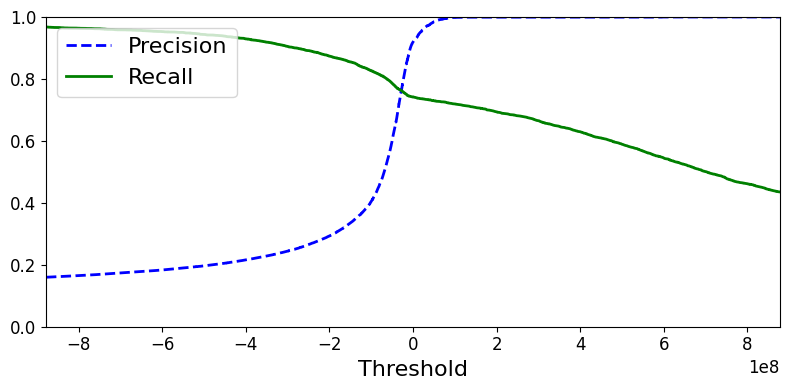

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([top, -top])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [ ]:
(y_train_pred == (y_scores > 0)).all()

True

Saving figure precision_vs_recall_plot


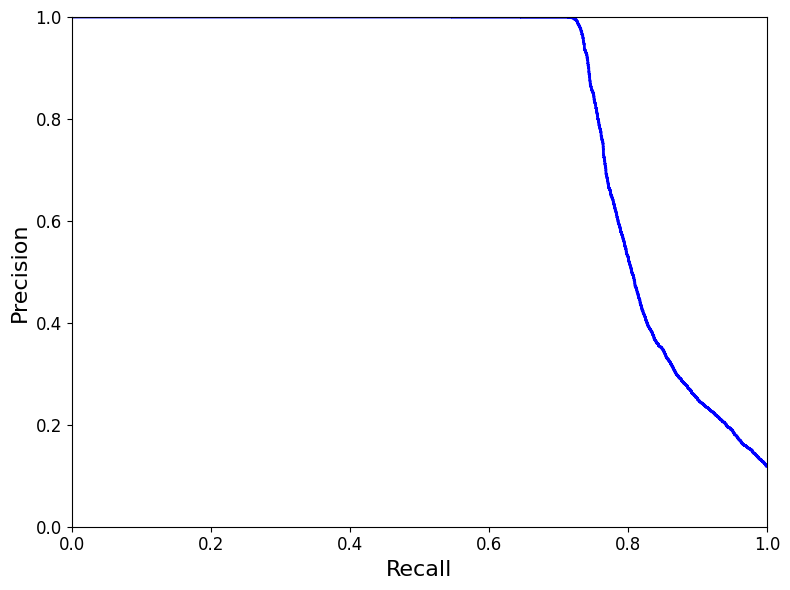

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

# ROC curves

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

Saving figure roc_curve_plot


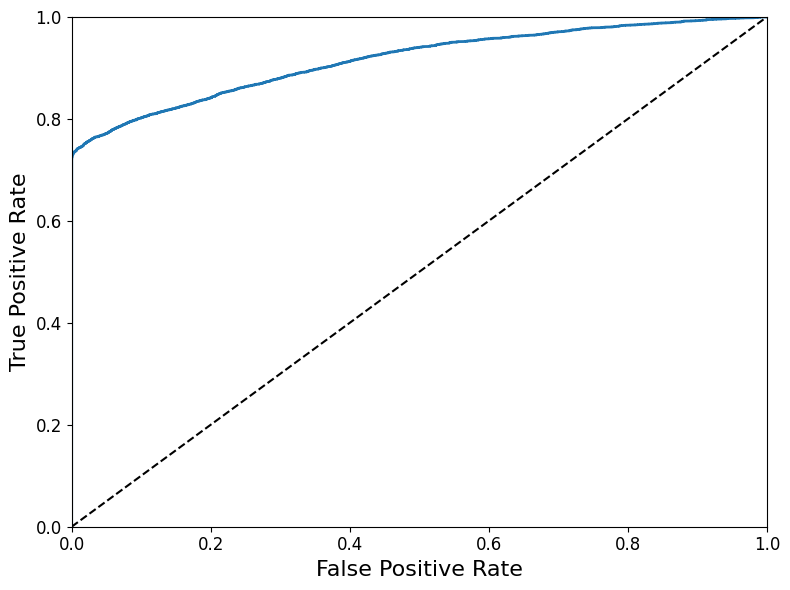

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, y_scores)

0.91560899622096

**Note**: we set `n_estimators=10` to avoid a warning about the fact that its default value will be set to 100 in Scikit-Learn 0.22.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3,
                                    method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train,y_scores_forest)

Saving figure roc_curve_comparison_plot


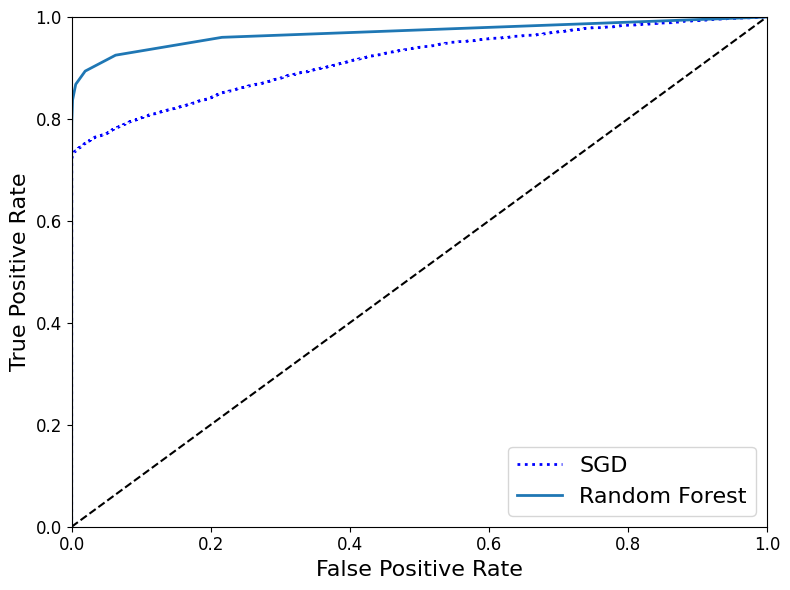

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [ ]:
roc_auc_score(y_train, y_scores_forest)

0.9690842469802384

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3)
precision_score(y_train, y_train_pred_forest)

0.9978802331743508

In [ ]:
recall_score(y_train, y_train_pred_forest)

0.7945147679324894

# Multiclass classification

In [ ]:
df["loan_status"].unique()

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'Late (16-30 days)',
       'Charged Off', 'In Grace Period', 'Default'], dtype=object)

In [ ]:
df["loan_status"].value_counts()

,count
loan_status,
Current,30438
Fully Paid,22147
Charged Off,5661
Late (31-120 days),917
In Grace Period,429
Late (16-30 days),140
Default,83


In [ ]:
class_names = ['Current', 'Fully Paid', 'Late (31-120 days)', 'Late (16-30 days)',
       'Charged Off', 'In Grace Period', 'Default']

In [ ]:
df["loan_status"] = df["loan_status"].replace({'Current':0, 'Fully Paid':1, 'Late (31-120 days)':2, 'Late (16-30 days)':3,
       'Charged Off':4, 'In Grace Period':5, 'Default':6})

In [ ]:
df["loan_status"].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
import numpy as np

X = df.drop(["loan_condition","loan_status"],axis=1).values
y = df["loan_status"].values

X_train, X_test, y_train, y_test = X[:40000], X[40000:], y[:40000], y[40000:]
shuffle_index = np.random.permutation(40000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([X_test[0]])

array([1])

In [ ]:
some_scores = sgd_clf.decision_function([X_test[0]])
some_scores

array([[-217250355.32371166, 723140625.2624027, -128539881.82149376,
        -120907265.95959485, -592268479.5415019, -84795661.47282602,
        -135480700.8681991]], dtype=object)

In [ ]:
np.argmax(some_scores)

1

In [ ]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
sgd_clf.classes_[5]

5

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=None, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([X_test[0]])

array([1])

In [ ]:
len(ovo_clf.estimators_)

21

In [ ]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([X_test[0]])

array([1])

In [ ]:
forest_clf.predict_proba([X_test[0]])

array([[0., 1., 0., 0., 0., 0., 0.]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.96325184, 0.95912398, 0.96204905])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.96640168, 0.9681992 , 0.96639916])

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[20574,    31,    69,     4,     7,    74,     0],
       [   82, 14405,     0,     0,    12,     2,     0],
       [  520,     0,   113,     0,     1,    14,     0],
       [   90,     0,     5,     0,     0,     4,     0],
       [   41,    16,     0,     1,  3585,     0,     0],
       [  274,     2,    13,     0,     0,     3,     0],
       [   38,     0,    19,     0,     0,     1,     0]])

In [ ]:
def plot_confusion_matrix(matrix, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = matrix
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[20574    31    69     4     7    74     0]
 [   82 14405     0     0    12     2     0]
 [  520     0   113     0     1    14     0]
 [   90     0     5     0     0     4     0]
 [   41    16     0     1  3585     0     0]
 [  274     2    13     0     0     3     0]
 [   38     0    19     0     0     1     0]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

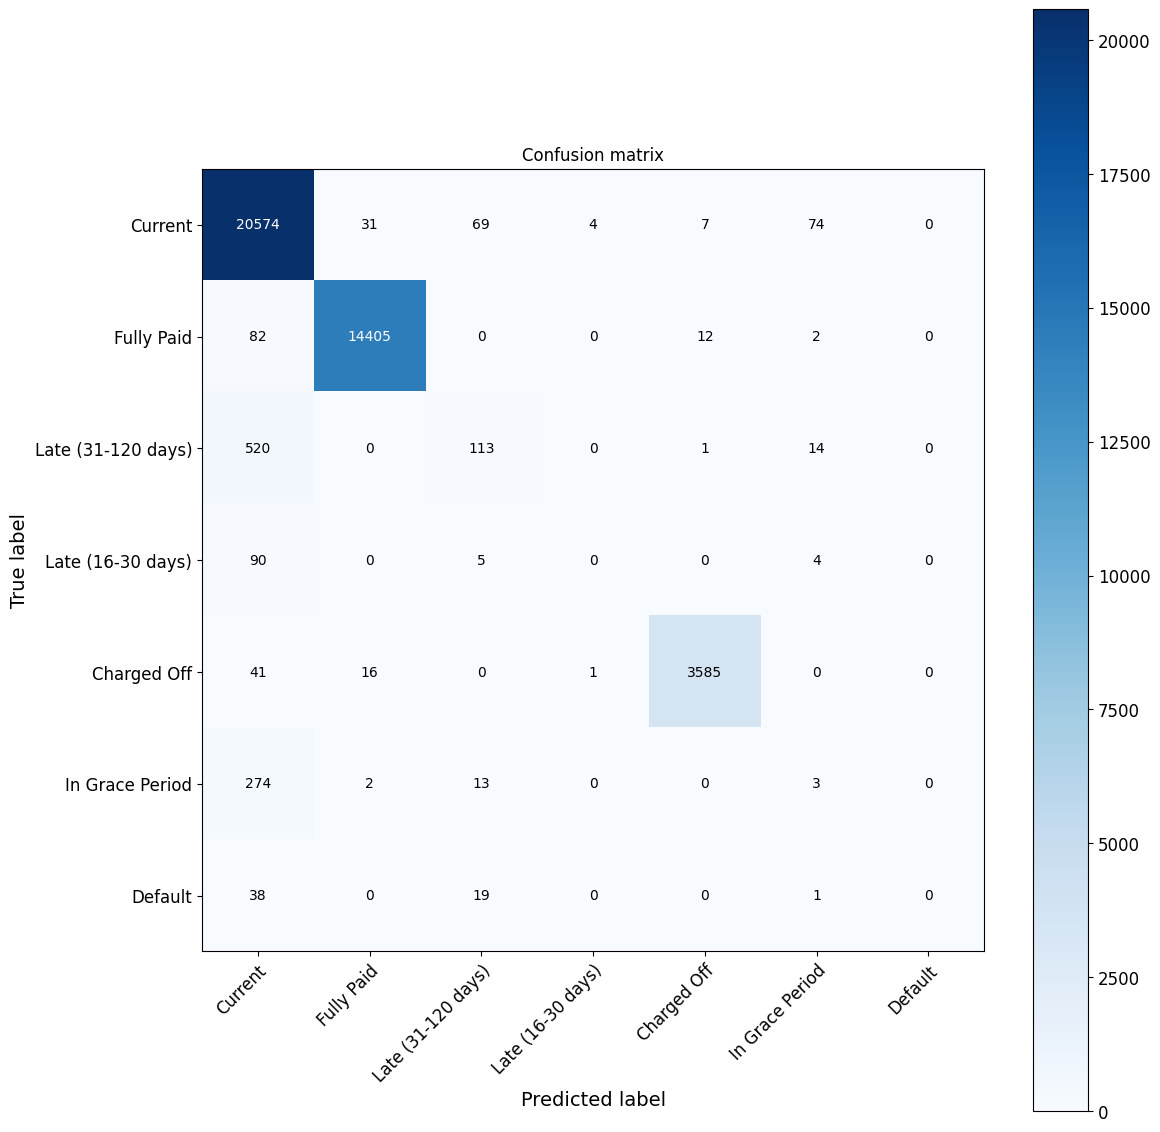

In [ ]:

plot_confusion_matrix(conf_mx
                      , classes=class_names
                      , title='Confusion matrix')